# Vehicle detection

In [75]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
import os
from sklearn.preprocessing import StandardScaler
import time

%matplotlib inline

### useful functions for pipeline

In [89]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                x1 = xbox_left
                y1 = ytop_draw+ystart
                x2 = xbox_left+win_draw
                y2 = ytop_draw+win_draw+ystart
                cv2.rectangle(draw_img,(x1, y1),(x2, y2),(0,0,255),6) 
                bbox_list.append(((x1, y1),(x2, y2)))
    return draw_img, bbox_list


### Data Preparation

In [19]:
import glob
import os

In [51]:

vehicle_path = glob.glob('./vehicles/*/*.png')
non_vehicle_path = glob.glob('./non-vehicles/*/*.png')
n_vehicle = len(vehicle_path)
n_non_vehicle = len(non_vehicle_path)
print("vehicle image total: ", n_vehicle)
print("Non vehicle image total: ",n_non_vehicle)


vehicle image total:  8792
Non vehicle image total:  8968


There is a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Text(0.5,1,'Example Not-car Image')

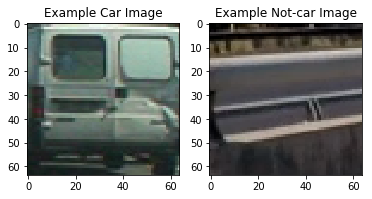

In [52]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(vehicle_path[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(vehicle_path, non_vehicle_path)

print('There is a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, n_vehicle)
notcar_ind = np.random.randint(0, n_non_vehicle)
    
# Read in car / not-car images
car_image = mpimg.imread(vehicle_path[car_ind])
notcar_image = mpimg.imread(non_vehicle_path[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


In [ ]:
def scale_up255(png_img):
    mparray = np.dot(png_img, 255)
    return mparray

### feature extraction

/Users/leon/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


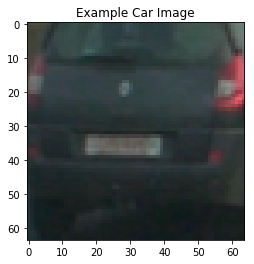

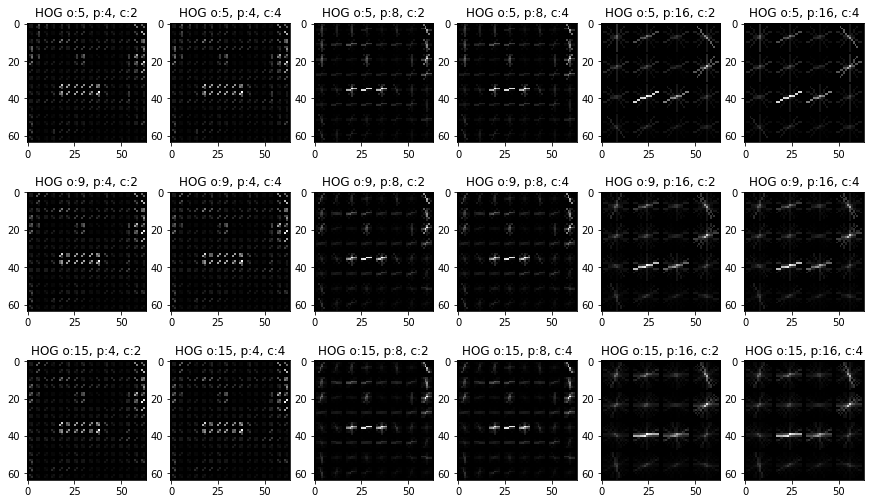

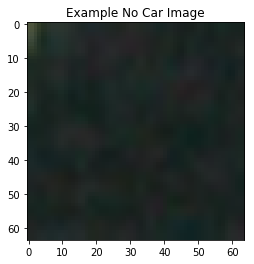

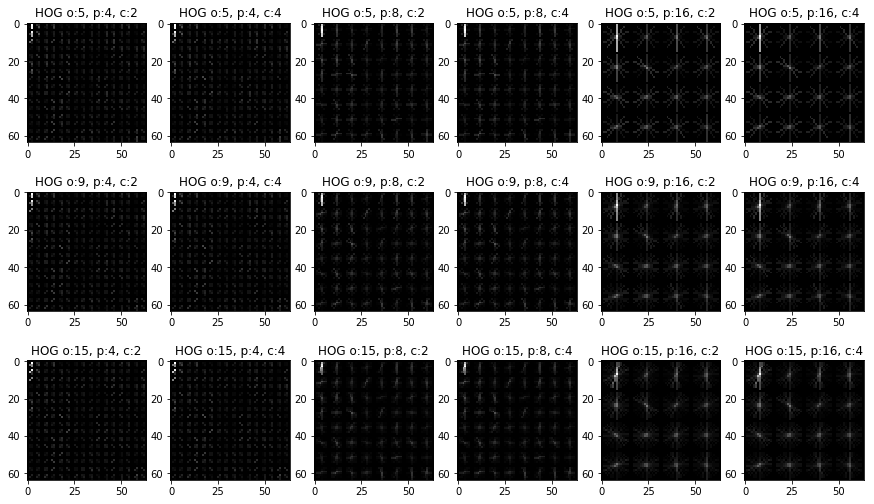

In [69]:
# Read in our vehicles and non-vehicles
cars = vehicle_path
notcars = non_vehicle_path
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                  cells_per_block=(cell_per_block, cell_per_block), 
                  visualise=vis, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Generate a random index to look at a no car image
ind2 = np.random.randint(0, len(notcars))
# Read in the image
image2 = mpimg.imread(notcars[ind2])
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

# Define HOG parameters list
orient = [5, 9, 15]
pix_per_cell = [4, 8, 16]
cell_per_block = [2, 4]

fig = plt.figure()
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')

fig = plt.figure(figsize=(15,15))
i=1
for ori in orient:
    for pix in pix_per_cell:
        for cell in cell_per_block:          
            # Call our function with vis=True to see an image output
            features, hog_image = get_hog_features(gray, ori, 
                                    pix, cell, 
                                    vis=True, feature_vec=False)
            # Plot the examples            
            plt.subplot(5,6,i)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG o:'+str(ori)+", p:"+str(pix)+", c:"+str(cell))
            i += 1

# non car
fig = plt.figure()
plt.imshow(image2, cmap='gray')
plt.title('Example No Car Image')

fig = plt.figure(figsize=(15,15))
i=1
for ori in orient:
    for pix in pix_per_cell:
        for cell in cell_per_block:          
            # Call our function with vis=True to see an image output
            features2, hog_image2 = get_hog_features(gray2, ori, 
                                    pix, cell, 
                                    vis=True, feature_vec=False)
            # Plot the examples            
            plt.subplot(5,6,i)
            plt.imshow(hog_image2, cmap='gray')
            plt.title('HOG o:'+str(ori)+", p:"+str(pix)+", c:"+str(cell))
            i += 1
# Call our function with vis=True to see an image output
#features2, hog_image2 = get_hog_features(gray2, orient, 
                        #pix_per_cell, cell_per_block, 
                        #vis=True, feature_vec=False)


In [154]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 3
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()

car_features = extract_features(vehicle_path, color_space=colorspace, spatial_size=(32, 32),
                        hist_bins=32, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(non_vehicle_path, color_space=colorspace, spatial_size=(32, 32),
                        hist_bins=32, cell_per_block=cell_per_block, hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

344.39 Seconds to extract features...


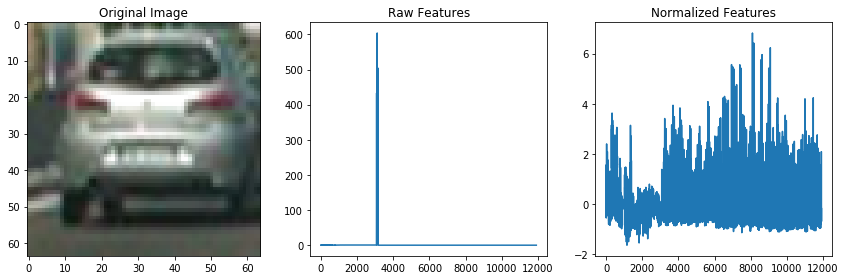

In [155]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, n_vehicle)
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_path[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


### train classifier

In [156]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 11916
518.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9947
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.13048 Seconds to predict 10 labels with SVC


In [157]:
import pickle
dist_pickle = {}

dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block

pickle.dump( dist_pickle, open( "./svc_pickle.p", "wb" ) )

### sliding window vehicle search

(720, 1280, 3)


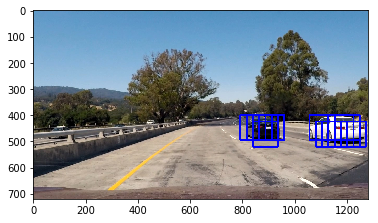

In [158]:
img_test = mpimg.imread('./test_images/test1.jpg')
fig = plt.figure()
#plt.imshow(img_test)
print(img_test.shape)

ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32, 32)
hist_bins=32
scale_list = [0.8, 1, 1.5, 2]
out_img, bbox_list = find_cars(img_test, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)


In [159]:
print(bbox_list)

[((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520))]


### tracking

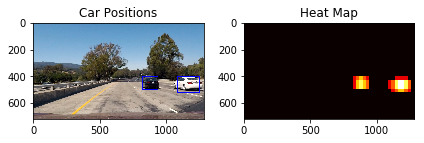

In [160]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

# Read in image similar to one shown above 
heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_test), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## video pipeline

In [224]:
from collections import deque
allbox = deque(maxlen=6)

def process_video(frame):
    ystart = 400
    ystop = 656
    #scale = 1.5
    spatial_size = (32, 32)
    hist_bins=32
    scale_list = [0.8, 1, 1.5, 2]
    #scale_list = []
    box = []
    for scale in scale_list:
        if(scale == 0.8):
            ystop = 550
        else:
            ystop = 656        
        out_img, bbox_list = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box.extend(bbox_list)
        
    allbox.append(box)
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    for ele in allbox:
        heat = add_heat(heat, ele)
    heat = apply_threshold(heat,8)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    return draw_img



## test on images first

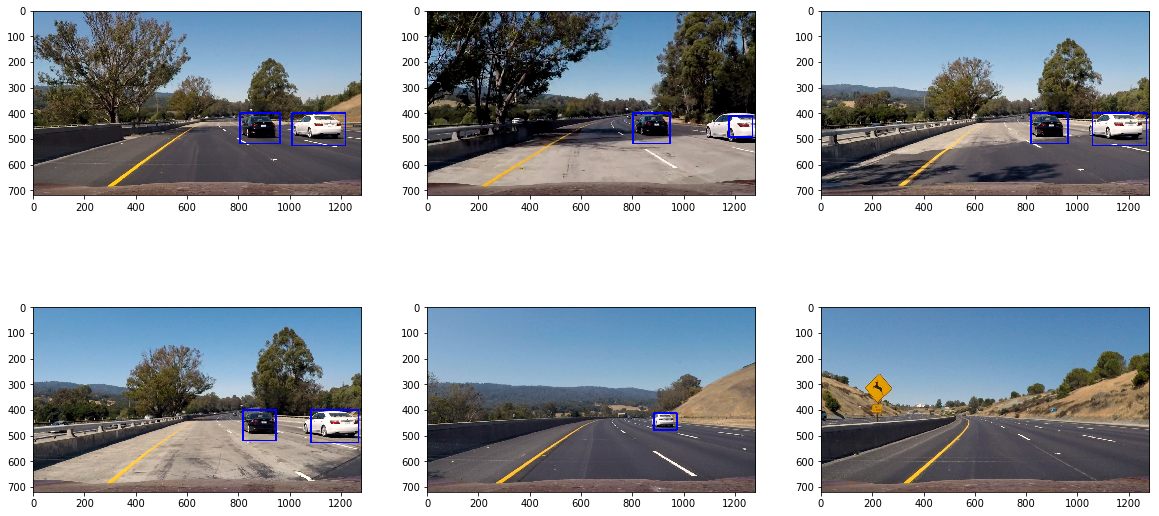

In [205]:
# test on image # should set head threshold = 2
frames = glob.glob('./test_images/test*.jpg')
plt.figure(figsize=(20, 10))
i=1
for frame_path in frames:
    frame = mpimg.imread(frame_path)
    #print(frame.shape)
    test_frame = process_video(frame)
    plt.subplot(2,3,i)
    i += 1
    plt.imshow(test_frame)
    allbox.clear()

In [208]:
print(len(allbox))


6


### test on frames then

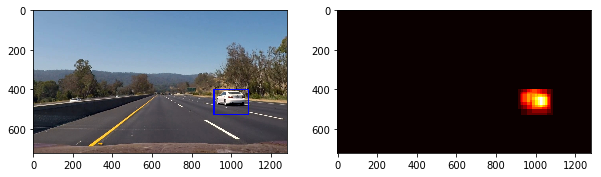

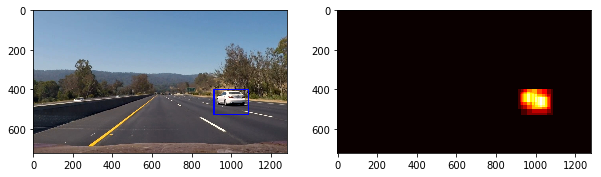

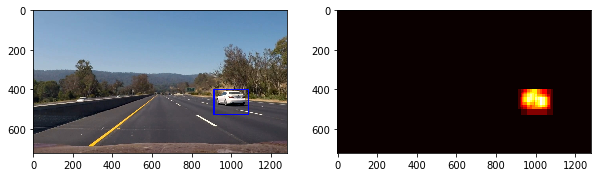

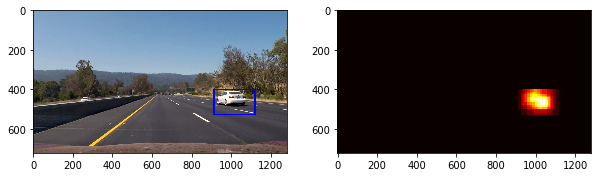

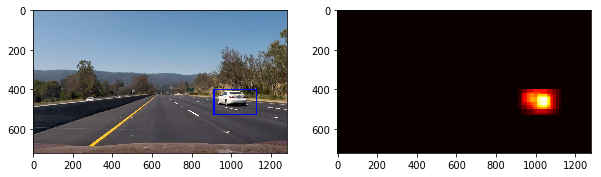

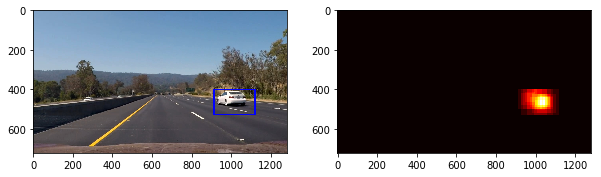

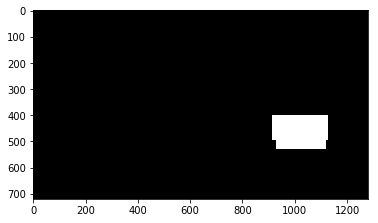

In [235]:
# test on image
frames = glob.glob('./proj_frames/frame*.jpg')
plt.figure(figsize=(20, 10))
i=1
frame0 = mpimg.imread(frames[0])
heatall = np.zeros_like(frame0[:,:,0]).astype(np.float)
for frame_path in frames:
    frame = mpimg.imread(frame_path)
    #print(frame.shape)
    #test_frame = process_video(frame)
    ystart = 400
    ystop = 656
    #scale = 1.5
    spatial_size = (32, 32)
    hist_bins=32
    scale_list = [0.8, 1, 1.5, 2]
    #scale_list = []
    box = []
    for scale in scale_list:
        if(scale == 0.8):
            ystop = 550
        else:
            ystop = 656        
        out_img, bbox_list = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box.extend(bbox_list)
        
    
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    heat = add_heat(heat, box)
    heatall = add_heat(heatall, box)
    #heat = apply_threshold(heat,8)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    #plt.subplot(133)
    #plt.imshow(labels[0], cmap='gray')
heatmap = np.clip(heatall, 0, 255)
labels = label(heatmap)
plt.figure()
plt.imshow(labels[0], cmap='gray')
allbox.clear()

## test on video


In [163]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [227]:
allbox.clear()
normal_output = 'output_videos/vehicle_detection.mp4'

clip1 = VideoFileClip("project_video.mp4")
normal_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time normal_clip.write_videofile(normal_output, audio=False)
allbox.clear()

[MoviePy] >>>> Building video output_videos/vehicle_detection.mp4
[MoviePy] Writing video output_videos/vehicle_detection.mp4


100%|█████████▉| 1260/1261 [1:11:02<00:04,  4.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/vehicle_detection.mp4 

CPU times: user 1h 8min 53s, sys: 2min, total: 1h 10min 53s
Wall time: 1h 11min 4s


In [228]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(normal_output))

In [179]:
def make_frame(src_file, dst_folder, max_num = 6):
    vidcap = cv2.VideoCapture(src_file)
    dst_path = dst_folder + '/frame%d.jpg'
    success,image = vidcap.read()
    count = 0
    index = 0
    success = True
    while success:  
        success,image = vidcap.read()

        if(count > 400):
            cv2.imwrite(dst_path % index, image)     # save frame as JPEG file
            print('Save a new frame: ', success)
            index += 1
        count += 1
        if(index >= max_num):
            success = False

In [180]:
make_frame('project_video.mp4', 'proj_frames')

Save a new frame:  True
Save a new frame:  True
Save a new frame:  True
Save a new frame:  True
Save a new frame:  True
Save a new frame:  True
